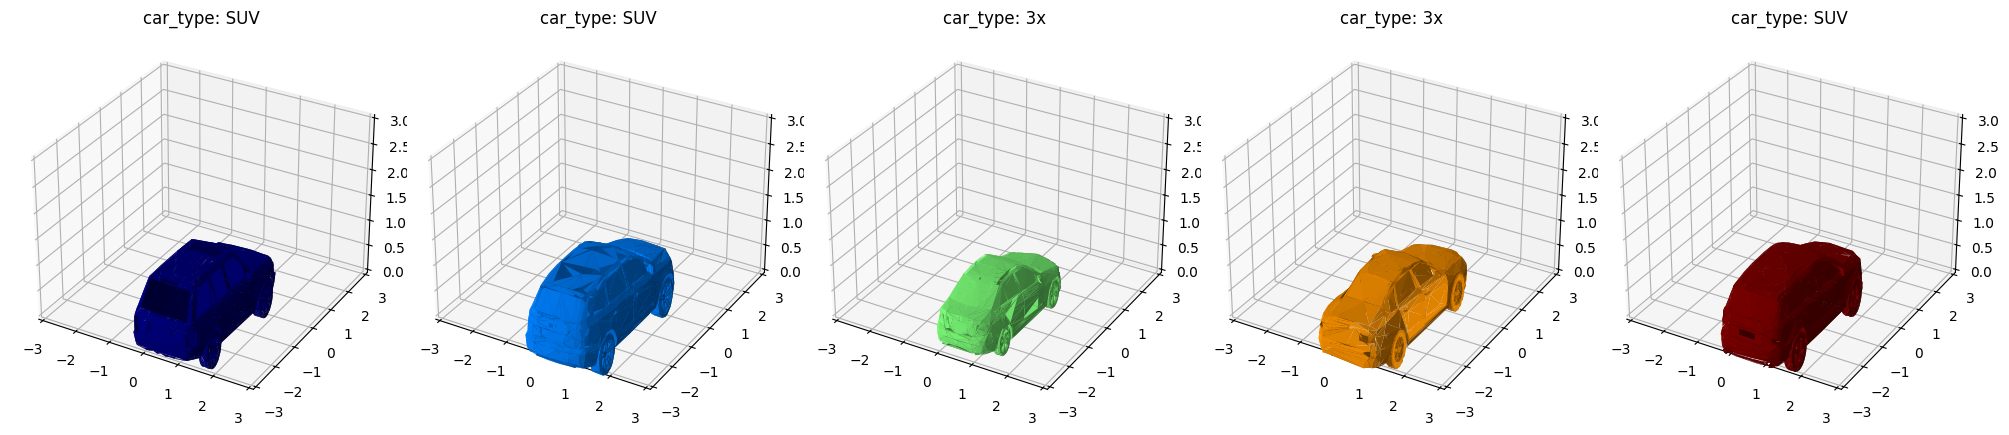

In [1]:
#!pip install numpy matplotlib mpl_toolkits json
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import pywavefront

def load_obj(filename):
    vertices = []  # List to store vertex positions

    # Open the file
    with open(filename, 'r') as file:
        # Iterate over each line
        for line in file:
            # Split the line into components
            parts = line.strip().split()
            # Check if this line describes a vertex
            if not parts or parts[0] != 'v':
                continue
            # Convert the vertex components to floats and add to the list
            vertex = tuple(map(float, parts[1:4]))  # Assumes vertex has x, y, z coordinates
            vertices.append(vertex)
                
    return vertices

# Load vertices from an OBJ file
vertices_human = load_obj('/workspace/data/FinalBaseMesh.obj')
vertices_bike = load_obj('/workspace/data/11717_bicycle_v2_L1.obj')

# Path to the folder containing JSON files
folder_path = "/workspace/datasets/apollo/car_models_json"

# List all JSON files in the folder
json_files = [f for f in os.listdir(folder_path) if f.endswith('.json')]

# Number of models to display
N = 5  # Adjust N as needed
colors = plt.cm.jet(np.linspace(0, 1, N))
# Create a figure and axes for 3D plotting
plt.figure(figsize=(20, 10))

# Iterate over the first N JSON files
for i,json_file_name in enumerate(json_files[:N]):
    with open(os.path.join(folder_path, json_file_name)) as json_file:
        data = json.load(json_file)
        vertices = np.array(data['vertices'])
        triangles = np.array(data['faces']) - 1

        # Create a new subplot for each model
        ax = plt.subplot(1, N, json_files.index(json_file_name) + 1, projection='3d')

        # Set the title, limits, and plot the model
        ax.set_title('car_type: ' + data['car_type'])
        ax.set_xlim([-3, 3])
        ax.set_ylim([-3, 3])
        ax.set_zlim([0, 3])
        ax.plot_trisurf(vertices[:, 0], vertices[:, 2], triangles, -vertices[:, 1], shade=True, color=colors[i])

# Adjust the layout
plt.tight_layout()
plt.show()


In [2]:
#print keys of json file
print(data.keys())

dict_keys(['car_type', 'vertices', 'faces'])


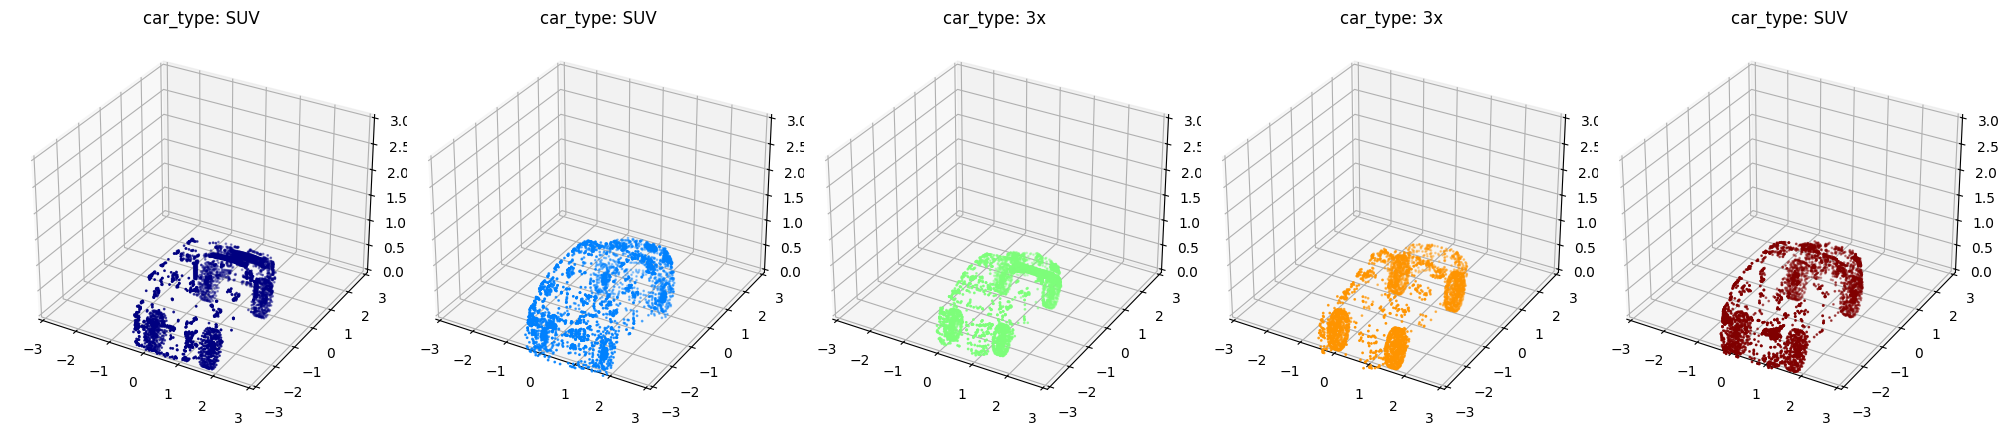

In [3]:
# Create a figure and axes for 3D plotting
plt.figure(figsize=(20, 10))
vertex_point_cloud = []
# Iterate over the first N JSON files
for i, json_file_name in enumerate(json_files[:N]):
    with open(os.path.join(folder_path, json_file_name)) as json_file:
        data = json.load(json_file)
        vertices = np.array(data['vertices'])

        # Create a new subplot for each model
        ax = plt.subplot(1, N, i + 1, projection='3d')

        # Set the title and limits
        ax.set_title('car_type: ' + data['car_type'])
        ax.set_xlim([-3, 3])
        ax.set_ylim([-3, 3])
        ax.set_zlim([0, 3])

        # Plot the vertices (points) with a unique color
        ax.scatter(vertices[:, 0], vertices[:, 2], -vertices[:, 1], color=colors[i], s=1)  # s is the size of points

        # Store the vertices in a list
        vertex_point_cloud.append(vertices)

# Adjust the layout
plt.tight_layout()
plt.show()

In [4]:
import os
from scipy.spatial.distance import cdist
from scipy.stats import wasserstein_distance
from itertools import combinations


def load_point_clouds(folder_path, json_files, N):
    point_clouds = {'SUV': [], '3x': [], '2x': []}
    for i, json_file_name in enumerate(json_files[:N]):
        with open(os.path.join(folder_path, json_file_name)) as json_file:
            data = json.load(json_file)
            vertices = np.array(data['vertices'])
            point_clouds[data['car_type']].append(vertices)
    return point_clouds

def earth_movers_distance(pc1, pc2):
    return sum(wasserstein_distance(pc1[:, i], pc2[:, i]) for i in range(pc1.shape[1]))

def manhattan_distance(pc1, pc2):
    dist_matrix = cdist(pc1, pc2, 'cityblock')
    return np.mean(dist_matrix.min(axis=1))

def chamfer_distance(pc1, pc2):
    dist_matrix = cdist(pc1, pc2, 'euclidean')
    return np.mean(dist_matrix.min(axis=1)) + np.mean(dist_matrix.min(axis=0))

point_clouds = load_point_clouds(folder_path, json_files, len(json_files))


In [5]:
manhattan_distances = {'SUV': [], '3x': [], '2x': []}
earth_movers_distances = {'SUV': [], '3x': [], '2x': []}
chamfer_distances = {'SUV': [], '3x': [], '2x': []}

base_point_cloud = point_clouds['SUV'][0]

for car_type in point_clouds:
    for pc in point_clouds[car_type]:
        manhattan_distances[car_type].append(manhattan_distance(base_point_cloud, pc))
        earth_movers_distances[car_type].append(earth_movers_distance(base_point_cloud, pc))
        chamfer_distances[car_type].append(chamfer_distance(base_point_cloud, pc))

In [6]:
#get average distance for each car type
avg_manhattan_distances = {car_type: np.mean(manhattan_distances[car_type]) for car_type in manhattan_distances}
avg_earth_movers_distances = {car_type: np.mean(earth_movers_distances[car_type]) for car_type in earth_movers_distances}
avg_chamfer_distances = {car_type: np.mean(chamfer_distances[car_type]) for car_type in chamfer_distances}

print('Average Manhattan distances:', avg_manhattan_distances)
print('Average Earth Movers distances:', avg_earth_movers_distances)
print('Average Chamfer distances:', avg_chamfer_distances)

Average Manhattan distances: {'SUV': 0.1328195278732979, '3x': 0.1536452759248564, '2x': 0.25983503958329446}
Average Earth Movers distances: {'SUV': 0.6135085753511653, '3x': 0.6137489783189178, '2x': 0.7766868483294748}
Average Chamfer distances: {'SUV': 0.20133067679966873, '3x': 0.22013010551231588, '2x': 0.342245558408977}


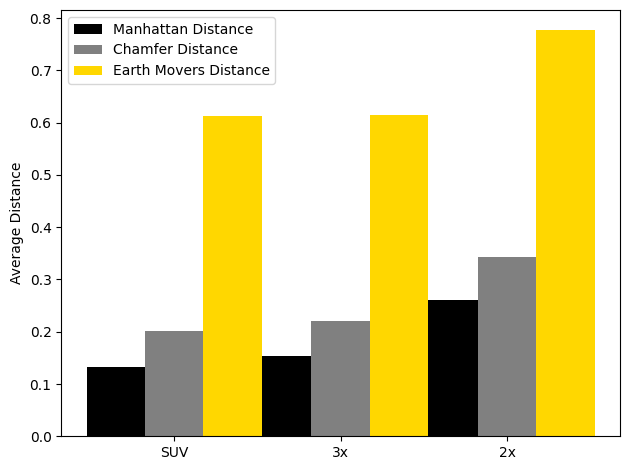

In [7]:
#plot as bar graph for each car type for both manhattan and earth movers distance
# Settings for the bars
bar_width = 0.35  # Width of the bars
index = np.arange(len(avg_manhattan_distances))  # Bar positions

# Create bars for Manhattan distances
plt.bar(index - bar_width, avg_manhattan_distances.values(), bar_width, color='black', label='Manhattan Distance')


plt.bar(index, avg_chamfer_distances.values(), bar_width, color='grey', label='Chamfer Distance')

# Create bars for Earth Movers distances
plt.bar(index + bar_width, avg_earth_movers_distances.values(), bar_width, color='gold', label='Earth Movers Distance')

# Labels, titles and legend
plt.ylabel('Average Distance')
plt.xticks(index, avg_manhattan_distances.keys())  # Set x-ticks to match the keys (car types)
plt.legend()

# Display the plot
plt.tight_layout()  # Adjust layout to not overlap
plt.show()



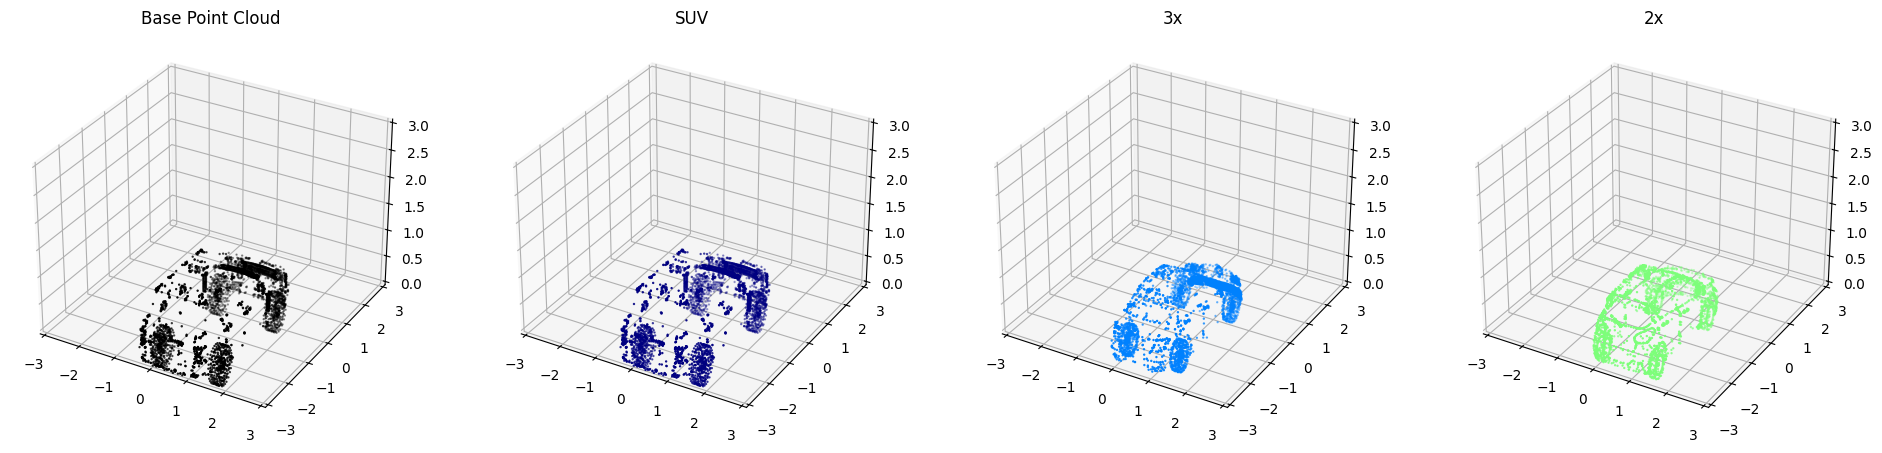

In [8]:
#plot base point cloud and point cloud of each car type
# Create a figure and axes for 3D plotting
plt.figure(figsize=(30, 20))

# Plot the base point cloud
ax = plt.subplot(1, N, 1, projection='3d')
ax.set_title('Base Point Cloud')
ax.set_xlim([-3, 3])
ax.set_ylim([-3, 3])
ax.set_zlim([0, 3])
ax.scatter(base_point_cloud[:, 0], base_point_cloud[:, 2], -base_point_cloud[:, 1], color='black', s=.5)

# Plot the point clouds of the other car types
for i, car_type in enumerate(point_clouds):
    for pc in point_clouds[car_type]:
        ax = plt.subplot(1, N, i + 2, projection='3d')
        ax.set_title(car_type)
        ax.set_xlim([-3, 3])
        ax.set_ylim([-3, 3])
        ax.set_zlim([0, 3])
        ax.scatter(pc[:, 0], pc[:, 2], -pc[:, 1], color=colors[i], s=.5)
        break

(24461, 3)


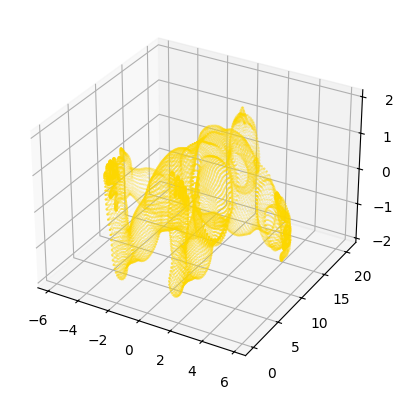

In [9]:
vertices_human = np.array(vertices_human)
print(vertices_human.shape)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(vertices_human[:,0], vertices_human[:,1], vertices_human[:,2], c="gold",s=.05)
plt.show()


(82212, 3)


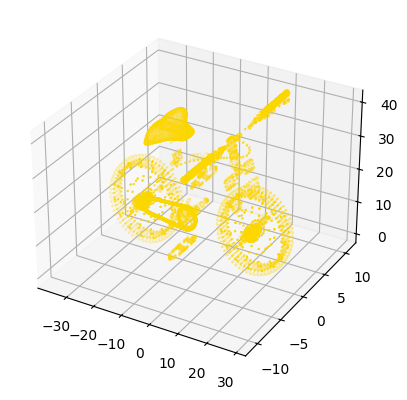

In [11]:
vertices_bike = np.array(vertices_bike)
print(vertices_bike.shape)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(vertices_bike[:,0], vertices_bike[:,1], vertices_bike[:,2], c="gold",s=.05)
plt.show()

In [12]:
import seaborn as sns
import pandas as pd

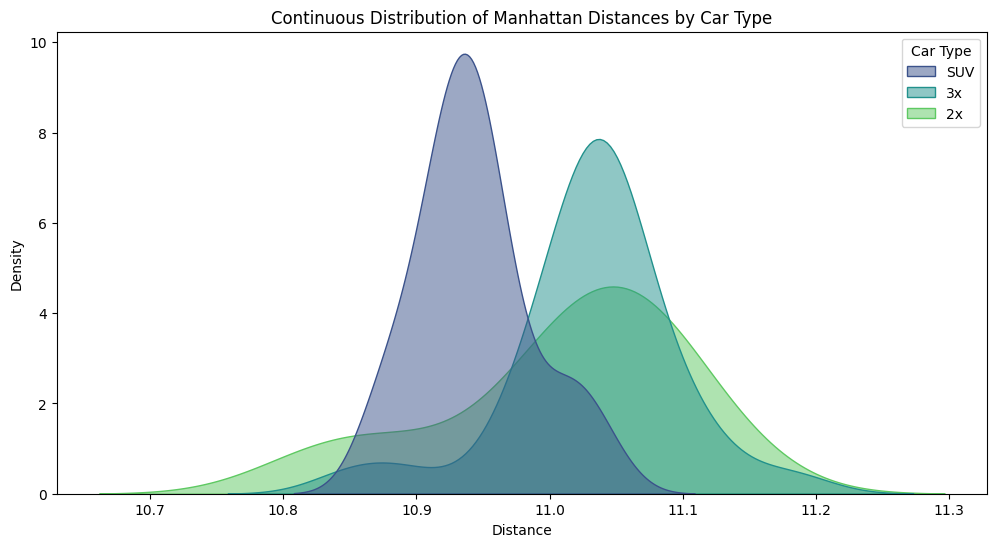

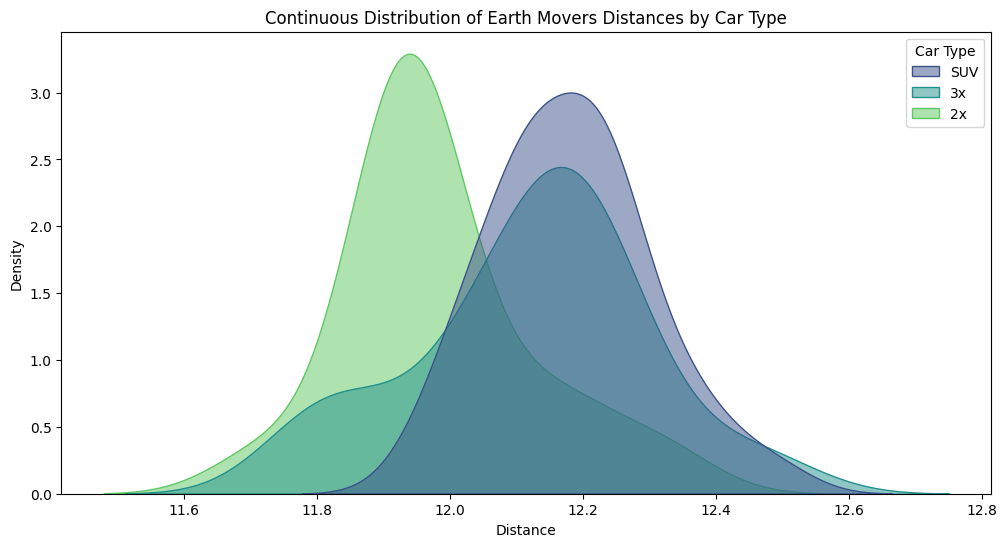

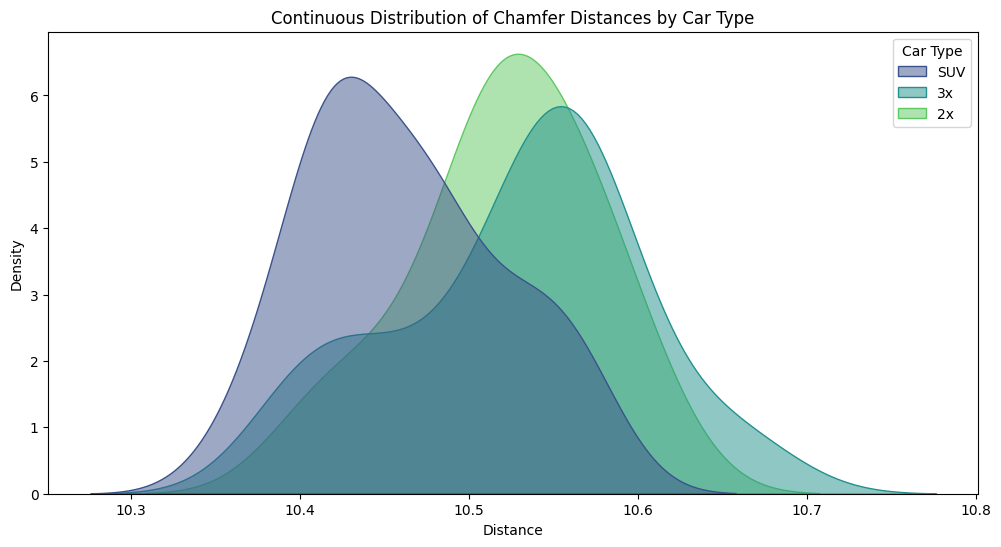

In [13]:
manhattan_distances_person = {'SUV': [], '3x': [], '2x': []}
earth_movers_distances_person = {'SUV': [], '3x': [], '2x': []}
chamfer_distances_person = {'SUV': [], '3x': [], '2x': []}



for car_type in point_clouds:
    for pc in point_clouds[car_type]:
        manhattan_distances_person[car_type].append(manhattan_distance(vertices_human, pc))
        earth_movers_distances_person[car_type].append(earth_movers_distance(vertices_human, pc))
        chamfer_distances_person[car_type].append(chamfer_distance(vertices_human, pc))

# Preparing the data frame
data_frames = []
for metric_name, distances_dict in [('Manhattan Distance', manhattan_distances_person), 
                                     ('Earth Movers Distance', earth_movers_distances_person),
                                     ('Chamfer Distance', chamfer_distances_person)]:
    for car_type, distances in distances_dict.items():
        for distance in distances:
            data_frames.append({'Car Type': car_type, 'Distance': distance, 'Metric': metric_name})
data = pd.DataFrame(data_frames)

# Plotting the KDE plots for each metric
plt.figure(figsize=(12, 6))
sns.kdeplot(data=data[data['Metric'] == 'Manhattan Distance'], x='Distance', hue='Car Type', fill=True, common_norm=False, alpha=0.5, palette="viridis")
plt.title('Continuous Distribution of Manhattan Distances by Car Type')
plt.xlabel('Distance')
plt.ylabel('Density')
plt.show()

plt.figure(figsize=(12, 6))
sns.kdeplot(data=data[data['Metric'] == 'Earth Movers Distance'], x='Distance', hue='Car Type', fill=True, common_norm=False, alpha=0.5, palette="viridis")
plt.title('Continuous Distribution of Earth Movers Distances by Car Type')
plt.xlabel('Distance')
plt.ylabel('Density')
plt.show()

plt.figure(figsize=(12, 6))
sns.kdeplot(data=data[data['Metric'] == 'Chamfer Distance'], x='Distance', hue='Car Type', fill=True, common_norm=False, alpha=0.5, palette="viridis")
plt.title('Continuous Distribution of Chamfer Distances by Car Type')
plt.xlabel('Distance')
plt.ylabel('Density')
plt.show()

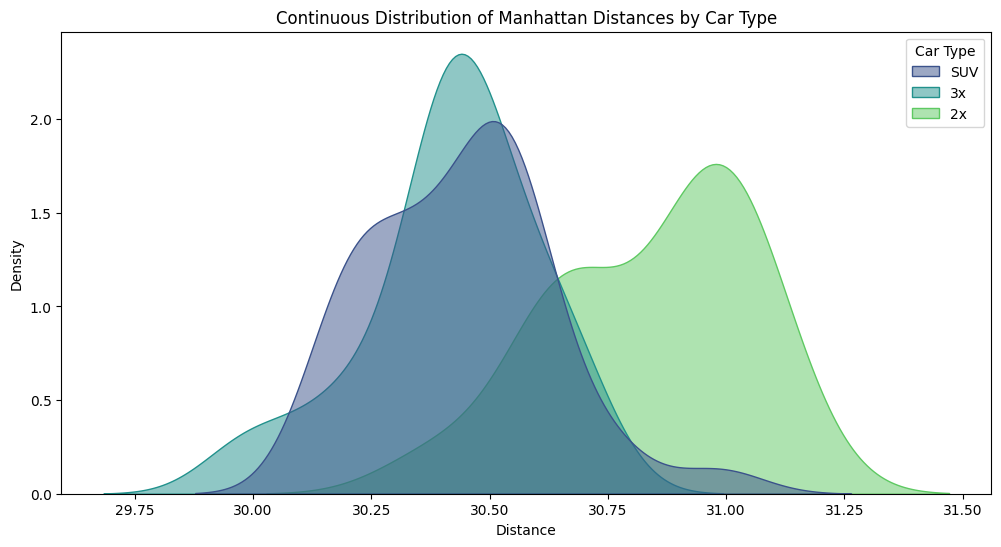

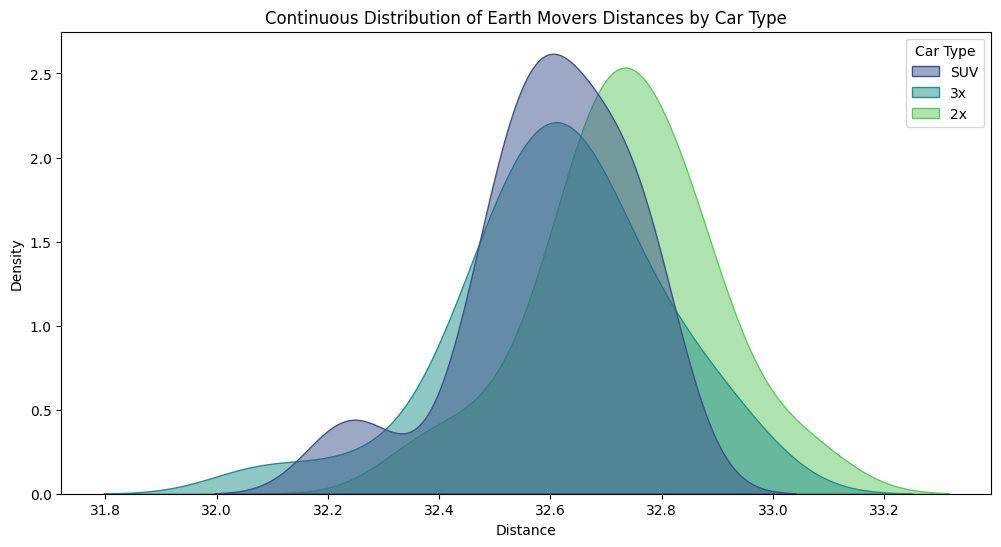

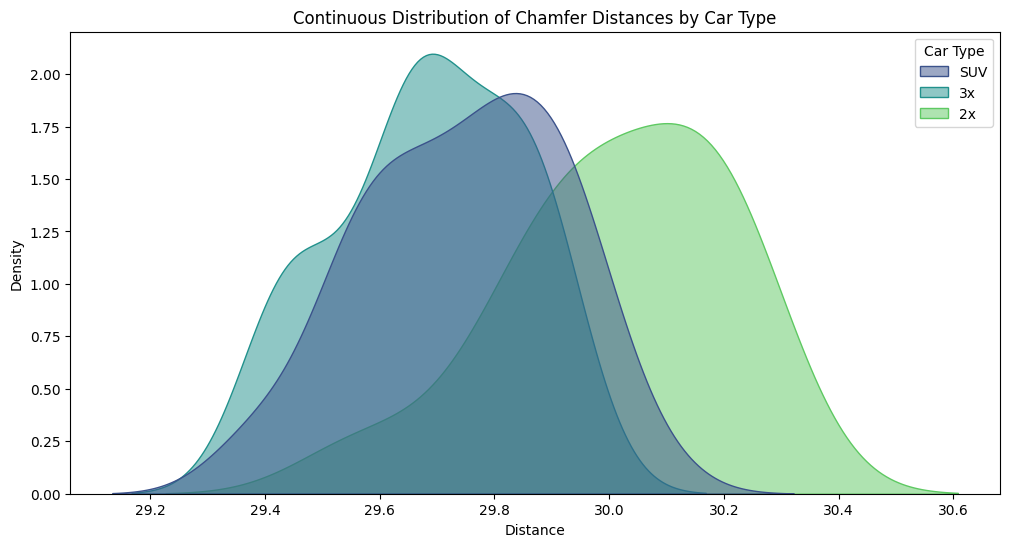

In [15]:
manhattan_distances_bike = {'SUV': [], '3x': [], '2x': []}
earth_movers_distances_bike = {'SUV': [], '3x': [], '2x': []}
chamfer_distances_bike = {'SUV': [], '3x': [], '2x': []}


# Correcting dictionary names in the loop
for car_type in point_clouds:
    for pc in point_clouds[car_type]:
        manhattan_distances_bike[car_type].append(manhattan_distance(vertices_bike, pc))
        earth_movers_distances_bike[car_type].append(earth_movers_distance(vertices_bike, pc))
        chamfer_distances_bike[car_type].append(chamfer_distance(vertices_bike, pc))

# Preparing the data frame
data_frames = []
for metric_name, distances_dict in [('Manhattan Distance', manhattan_distances_bike), 
                                     ('Earth Movers Distance', earth_movers_distances_bike),
                                     ('Chamfer Distance', chamfer_distances_bike)]:
    for car_type, distances in distances_dict.items():
        for distance in distances:
            data_frames.append({'Car Type': car_type, 'Distance': distance, 'Metric': metric_name})
data = pd.DataFrame(data_frames)

# Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the KDE plots for each metric
plt.figure(figsize=(12, 6))
sns.kdeplot(data=data[data['Metric'] == 'Manhattan Distance'], x='Distance', hue='Car Type', fill=True, common_norm=False, alpha=0.5, palette="viridis")
plt.title('Continuous Distribution of Manhattan Distances by Car Type')
plt.xlabel('Distance')
plt.ylabel('Density')
plt.show()

plt.figure(figsize=(12, 6))
sns.kdeplot(data=data[data['Metric'] == 'Earth Movers Distance'], x='Distance', hue='Car Type', fill=True, common_norm=False, alpha=0.5, palette="viridis")
plt.title('Continuous Distribution of Earth Movers Distances by Car Type')
plt.xlabel('Distance')
plt.ylabel('Density')
plt.show()

plt.figure(figsize=(12, 6))
sns.kdeplot(data=data[data['Metric'] == 'Chamfer Distance'], x='Distance', hue='Car Type', fill=True, common_norm=False, alpha=0.5, palette="viridis")
plt.title('Continuous Distribution of Chamfer Distances by Car Type')
plt.xlabel('Distance')
plt.ylabel('Density')
plt.show()


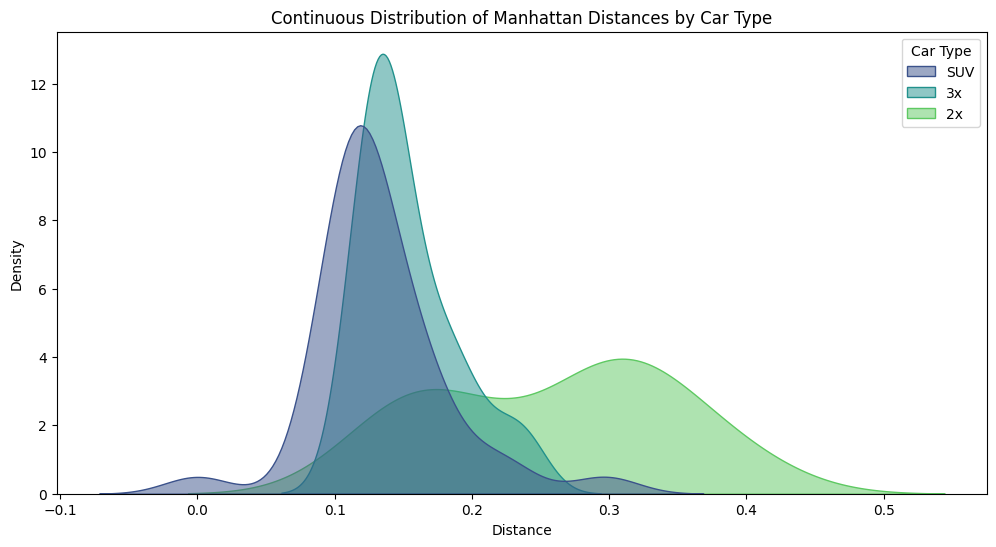

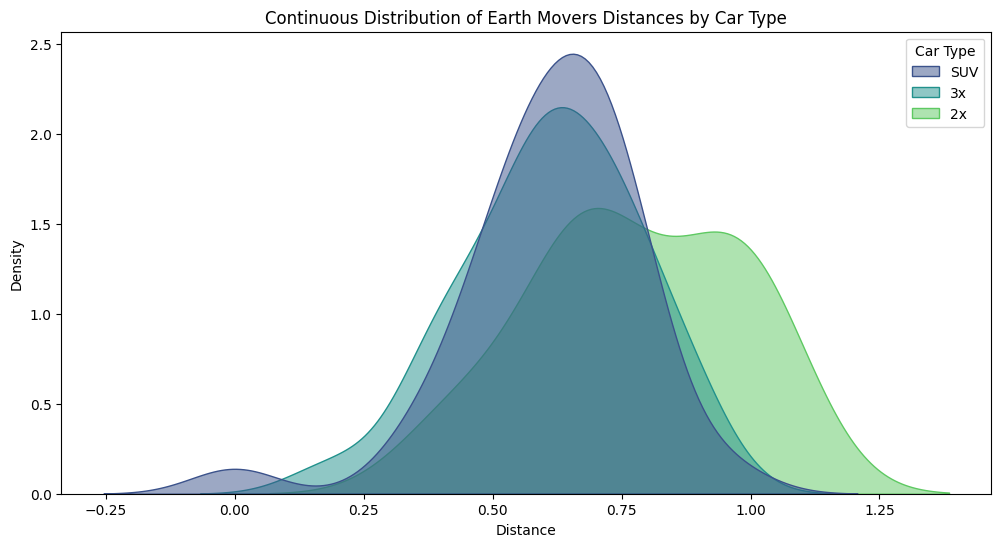

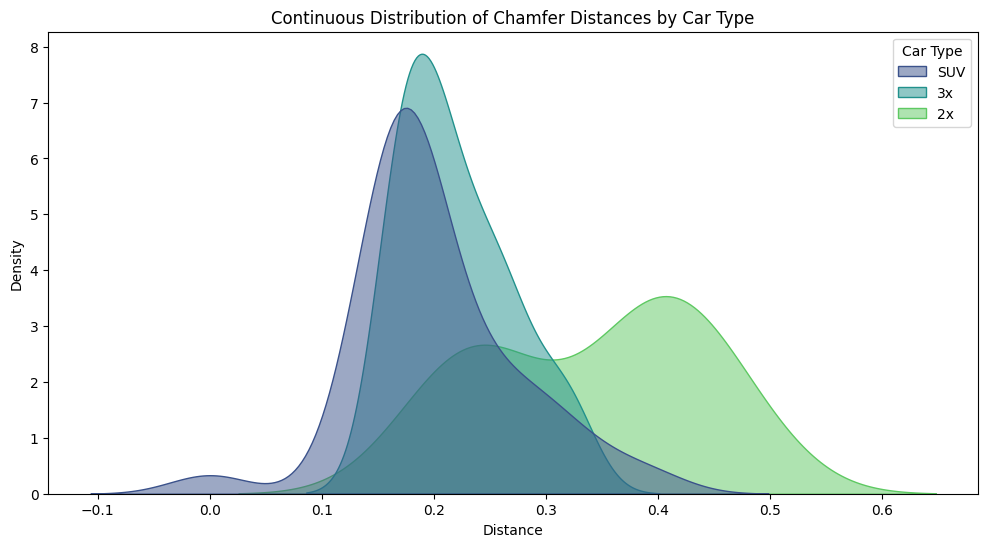

In [16]:



data_frames = []
for metric_name, distances_dict in [('Manhattan Distance', manhattan_distances), 
                                     ('Earth Movers Distance', earth_movers_distances),
                                     ('Chamfer Distance', chamfer_distances)]:
    for car_type, distances in distances_dict.items():
        for distance in distances:
            data_frames.append({'Car Type': car_type, 'Distance': distance, 'Metric': metric_name})
data = pd.DataFrame(data_frames)

# Now, plot the KDE plots for each metric separately
plt.figure(figsize=(12, 6))

# Filter data for Manhattan Distances and plot
manhattan_data = data[data['Metric'] == 'Manhattan Distance']
sns.kdeplot(data=manhattan_data, x='Distance', hue='Car Type', fill=True, common_norm=False, alpha=0.5, palette="viridis")
plt.title('Continuous Distribution of Manhattan Distances by Car Type')
plt.xlabel('Distance')
plt.ylabel('Density')
plt.show()

# Filter data for Earth Movers Distances and plot
plt.figure(figsize=(12, 6))
earth_movers_data = data[data['Metric'] == 'Earth Movers Distance']
sns.kdeplot(data=earth_movers_data, x='Distance', hue='Car Type', fill=True, common_norm=False, alpha=0.5, palette="viridis")
plt.title('Continuous Distribution of Earth Movers Distances by Car Type')
plt.xlabel('Distance')
plt.ylabel('Density')
plt.show()

# Filter data for Chamfer Distances and plot
plt.figure(figsize=(12, 6))
chamfer_data = data[data['Metric'] == 'Chamfer Distance']
sns.kdeplot(data=chamfer_data, x='Distance', hue='Car Type', fill=True, common_norm=False, alpha=0.5, palette="viridis")
plt.title('Continuous Distribution of Chamfer Distances by Car Type')
plt.xlabel('Distance')
plt.ylabel('Density')
plt.show()



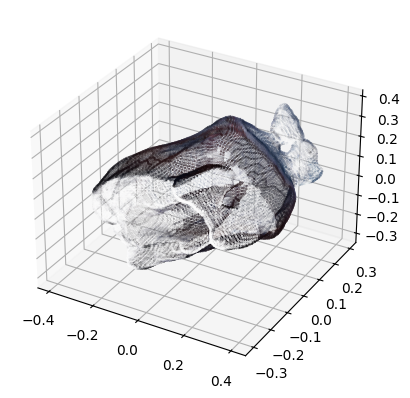

In [25]:
import trimesh
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load the OBJ file
mesh = trimesh.load_mesh('/workspace/_tmp_gradio_cdc98a505af4815949fb606e621845ff316bc522_mesh.obj')

synthetic_pc = mesh.vertices

colors = mesh.visual.vertex_colors

# Create a scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(synthetic_pc[:,0], synthetic_pc[:,1], synthetic_pc[:,2], c=colors/255,s=.05)
plt.show()

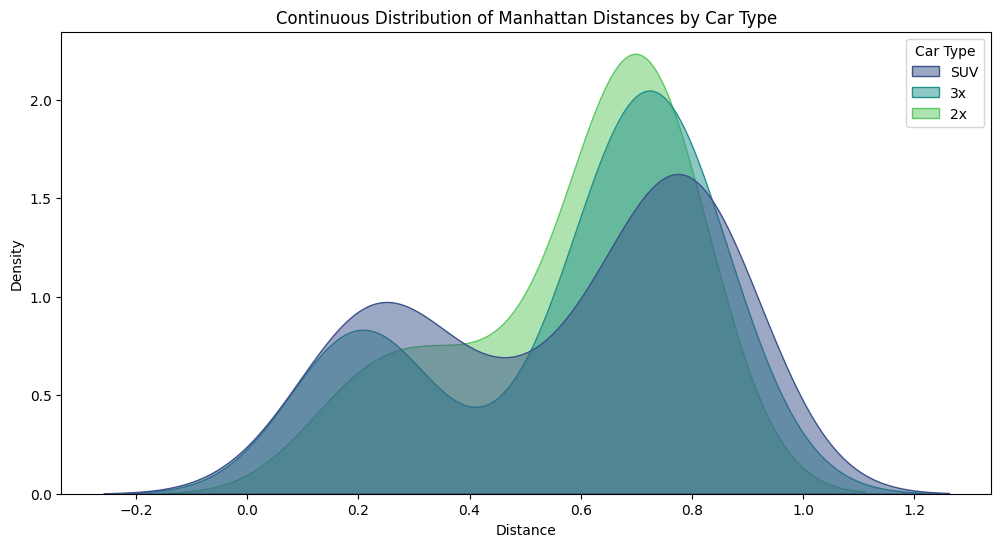

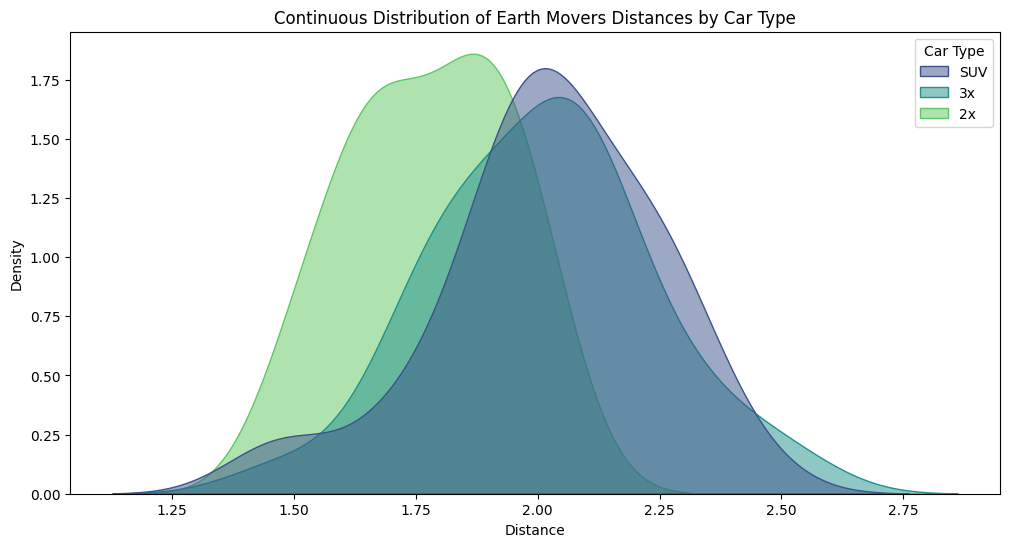

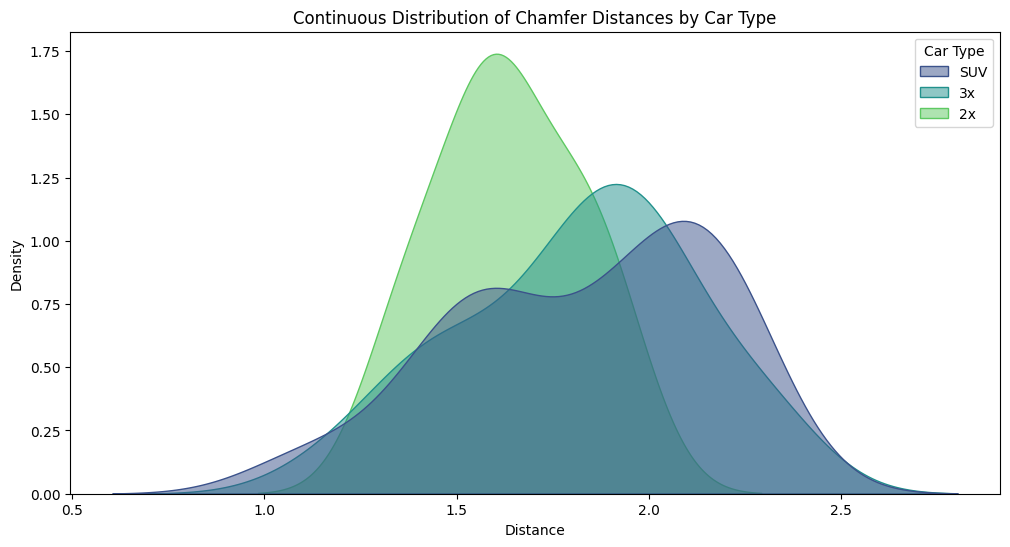

In [22]:
manhattan_distances_synth = {'SUV': [], '3x': [], '2x': []}
earth_movers_distances_synth = {'SUV': [], '3x': [], '2x': []}
chamfer_distances_synth = {'SUV': [], '3x': [], '2x': []}


# Correcting dictionary names in the loop
for car_type in point_clouds:
    for pc in point_clouds[car_type]:
        manhattan_distances_synth[car_type].append(manhattan_distance(synthetic_pc, pc))
        earth_movers_distances_synth[car_type].append(earth_movers_distance(synthetic_pc, pc))
        chamfer_distances_synth[car_type].append(chamfer_distance(synthetic_pc, pc))

# Preparing the data frame
data_frames = []
for metric_name, distances_dict in [('Manhattan Distance', manhattan_distances_synth), 
                                     ('Earth Movers Distance', earth_movers_distances_synth),
                                     ('Chamfer Distance', chamfer_distances_synth)]:
    for car_type, distances in distances_dict.items():
        for distance in distances:
            data_frames.append({'Car Type': car_type, 'Distance': distance, 'Metric': metric_name})
data = pd.DataFrame(data_frames)

# Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the KDE plots for each metric
plt.figure(figsize=(12, 6))
sns.kdeplot(data=data[data['Metric'] == 'Manhattan Distance'], x='Distance', hue='Car Type', fill=True, common_norm=False, alpha=0.5, palette="viridis")
plt.title('Continuous Distribution of Manhattan Distances by Car Type')
plt.xlabel('Distance')
plt.ylabel('Density')
plt.show()

plt.figure(figsize=(12, 6))
sns.kdeplot(data=data[data['Metric'] == 'Earth Movers Distance'], x='Distance', hue='Car Type', fill=True, common_norm=False, alpha=0.5, palette="viridis")
plt.title('Continuous Distribution of Earth Movers Distances by Car Type')
plt.xlabel('Distance')
plt.ylabel('Density')
plt.show()

plt.figure(figsize=(12, 6))
sns.kdeplot(data=data[data['Metric'] == 'Chamfer Distance'], x='Distance', hue='Car Type', fill=True, common_norm=False, alpha=0.5, palette="viridis")
plt.title('Continuous Distribution of Chamfer Distances by Car Type')
plt.xlabel('Distance')
plt.ylabel('Density')
plt.show()

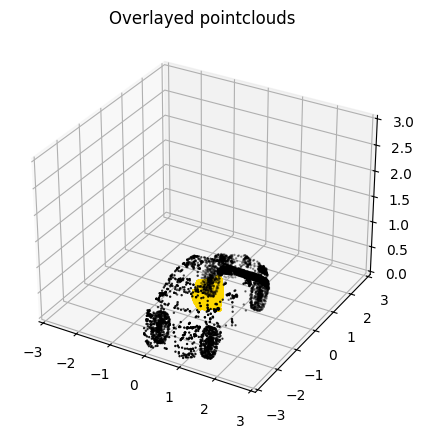

In [26]:
#compare two point clouds

plt.figure(figsize=(5, 5))

twox_point_cloud = point_clouds['3x'][0]

ax = plt.subplot(1, 1, 1, projection='3d')
ax.set_title('Overlayed pointclouds')
ax.set_xlim([-3, 3])
ax.set_ylim([-3, 3])
ax.set_zlim([0, 3])
ax.scatter(synthetic_pc[:, 0], synthetic_pc[:, 2], -synthetic_pc[:, 1], color='gold', s=.05)
ax.scatter(twox_point_cloud[:, 0], twox_point_cloud[:, 2], -twox_point_cloud[:, 1], color='black', s=.5)


In [27]:
import torch
import torch.nn as nn
import math
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
class PointCloudTransformer(nn.Module):
    def __init__(self):
        super(PointCloudTransformer, self).__init__()
        # Initialize parameters with small random values for rotation and translation, and 1 for scaling
        self.tx = nn.Parameter(torch.randn(1) * 0.01)
        self.ty = nn.Parameter(torch.randn(1) * 0.01)
        self.tz = nn.Parameter(torch.randn(1) * 0.01)
        self.theta_x = nn.Parameter(torch.randn(1) * 0.01)
        self.theta_y = nn.Parameter(torch.randn(1) * 0.01)
        self.theta_z = nn.Parameter(torch.randn(1) * 0.01)
        self.s = nn.Parameter(torch.ones(1))
        
    def forward(self, points):
        # Ensure all tensors created here are on the same device as `points`
        S = torch.diag(torch.stack([self.s.squeeze(), self.s.squeeze(), self.s.squeeze(), torch.tensor(1.0, device=points.device)])).to(points.device)
        Rx = torch.tensor([
            [1, 0, 0, 0],
            [0, torch.cos(self.theta_x), -torch.sin(self.theta_x), 0],
            [0, torch.sin(self.theta_x), torch.cos(self.theta_x), 0],
            [0, 0, 0, 1]
        ], device=points.device, requires_grad=True)
        
        Ry = torch.tensor([
            [torch.cos(self.theta_y), 0, torch.sin(self.theta_y), 0],
            [0, 1, 0, 0],
            [-torch.sin(self.theta_y), 0, torch.cos(self.theta_y), 0],
            [0, 0, 0, 1]
        ], device=points.device, requires_grad=True)
        
        Rz = torch.tensor([
            [torch.cos(self.theta_z), -torch.sin(self.theta_z), 0, 0],
            [torch.sin(self.theta_z), torch.cos(self.theta_z), 0, 0],
            [0, 0, 1, 0],
            [0, 0, 0, 1]
        ], device=points.device, requires_grad=True)
        
        T = torch.tensor([
            [1, 0, 0, self.tx],
            [0, 1, 0, self.ty],
            [0, 0, 1, self.tz],
            [0, 0, 0, 1]
        ], device=points.device, requires_grad=True)
        
        M = T.mm(Rz).mm(Ry).mm(Rx).mm(S)
        transformed_points = torch.mm(points, M.t())
        
        return transformed_points

Using device: cuda


(4646, 3) (35974, 3)


Iteration 1, Loss: 2.456261157989502


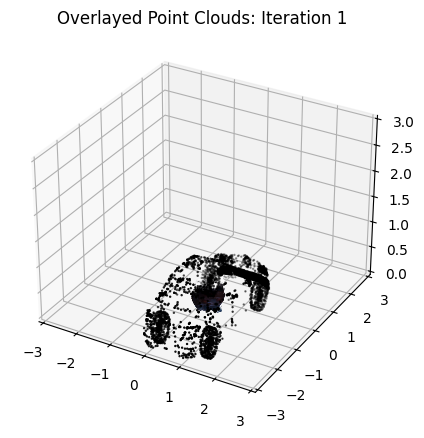

Iteration 2, Loss: 1.5792081356048584


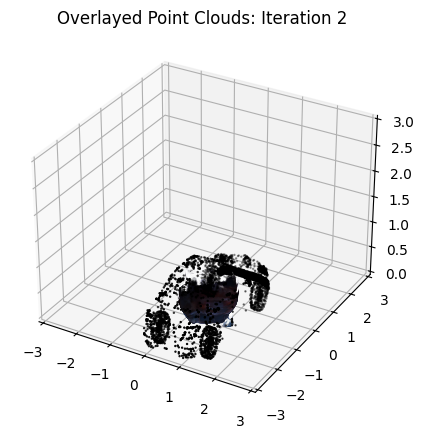

Iteration 3, Loss: 1.118628978729248


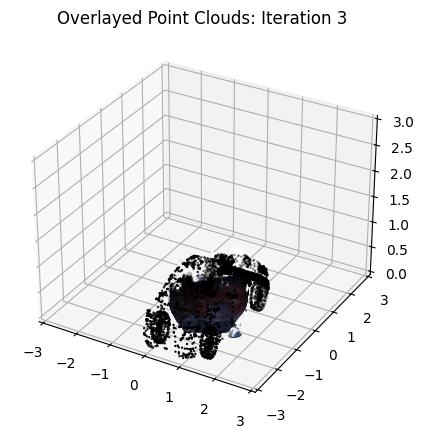

Iteration 4, Loss: 0.8906723260879517


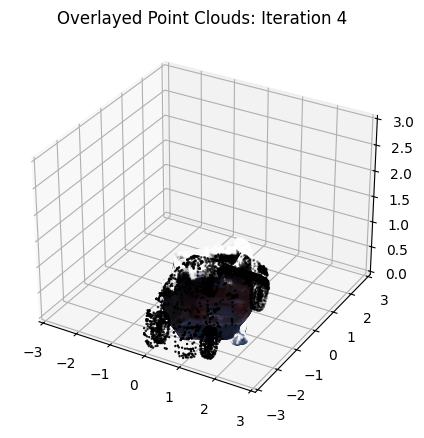

Iteration 5, Loss: 0.7764528393745422


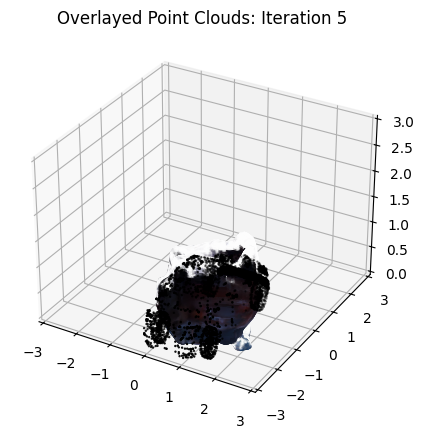

Iteration 6, Loss: 0.7169971466064453


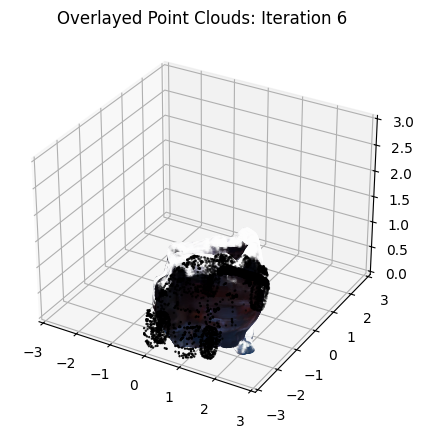

Iteration 7, Loss: 0.6853313446044922


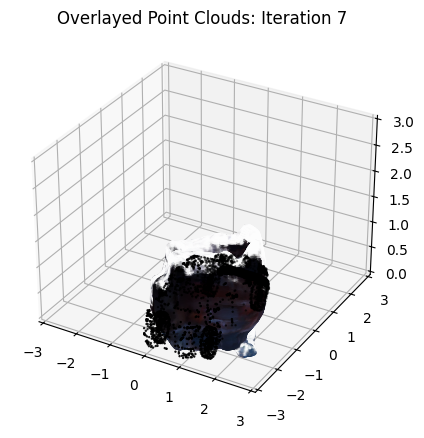

Iteration 8, Loss: 0.668259859085083


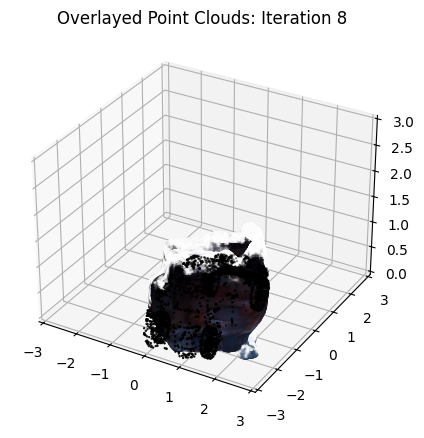

Iteration 9, Loss: 0.658896803855896


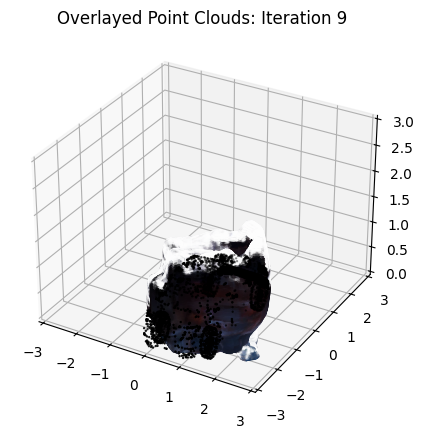

Iteration 10, Loss: 0.6537768840789795


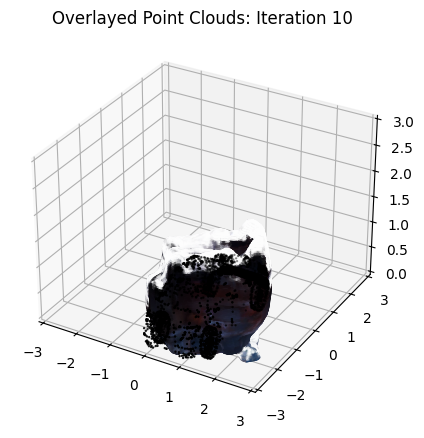

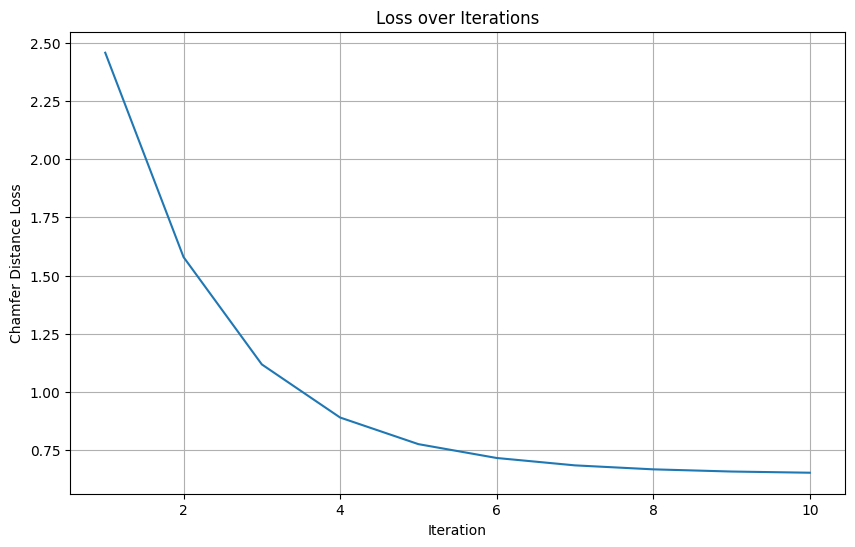

In [28]:
import torch.optim as optim

def chamfer_distance(pc1, pc2):
    """
    Calculate the Chamfer Distance between two point clouds.
    """
    pc1 = pc1[:, :3]  # Ensure pc1 is only x, y, z
    pc2 = pc2[:, :3]  # Ensure pc2 is only x, y, z
    
    pc1 = pc1.unsqueeze(1)  # Add batch dim
    pc2 = pc2.unsqueeze(0)  # Add batch dim
    
    dist = torch.sum((pc1 - pc2) ** 2, 2)
    min_dist_pc1_to_pc2 = torch.min(dist, 1)[0]
    min_dist_pc2_to_pc1 = torch.min(dist, 0)[0]
    
    return torch.mean(min_dist_pc1_to_pc2) + torch.mean(min_dist_pc2_to_pc1)

print(twox_point_cloud.shape, synthetic_pc.shape)
twax_pc_homo = torch.tensor(np.hstack((twox_point_cloud, np.ones((twox_point_cloud.shape[0], 1)))), dtype=torch.float32).to(device)
synthetic_pc_homo = torch.tensor(np.hstack((synthetic_pc, np.ones((synthetic_pc.shape[0], 1)))), dtype=torch.float32).to(device)
# Step 2: Set Up the Optimization Loop
# Initialize the transformer
transformer = PointCloudTransformer().to(device)

# Target point cloud (make sure to define this)
target_points = twax_pc_homo


# Initialize the optimizer
optimizer = optim.SGD(transformer.parameters(), lr=.8)

# Dummy source point cloud for demonstration
source_points = synthetic_pc_homo

num_iterations = 10
loss_record = []

# Move source and target points to device
source_points = source_points.to(device)  # Make sure source_points are in the correct format and on GPU
target_points = target_points.to(device)  # Make sure target_points are in the correct format and on GPU

for i in range(num_iterations):
    optimizer.zero_grad()
    
    # Apply transformation
    transformed_points = transformer(source_points)
    
    # Compute Chamfer Distance Loss
    loss = chamfer_distance(transformed_points, target_points)
    
    # Backpropagation
    loss.backward()
    optimizer.step()
    
    # Record loss for plotting
    loss_record.append(loss.item())
    
    print(f"Iteration {i+1}, Loss: {loss.item()}")

    # Plotting the transformation after each iteration
    transformed_points_np = transformed_points.detach().cpu().numpy()[:, :3]
    target_points_np = target_points.detach().cpu().numpy()[:, :3]  # Assuming target_points is also in homogeneous coordinates
    
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.clear()
    ax.set_title(f'Overlayed Point Clouds: Iteration {i+1}')
    ax.set_xlim([-3, 3])
    ax.set_ylim([-3, 3])
    ax.set_zlim([0, 3])
    
    # Adjusting the plotting as per the given format
    ax.scatter(transformed_points_np[:, 0], transformed_points_np[:, 2], -transformed_points_np[:, 1], c=colors/255.0, s=0.5)
    ax.scatter(target_points_np[:, 0], target_points_np[:, 2], -target_points_np[:, 1], color='black', s=0.5)
    
    plt.show()

# Graph the loss after all iterations
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_iterations + 1), loss_record)
plt.title('Loss over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Chamfer Distance Loss')
plt.grid(True)
plt.show()

In [29]:
# Access translation parameters
tx = transformer.tx.item()
ty = transformer.ty.item()
tz = transformer.tz.item()

# Access rotation parameters (in radians)
theta_x = transformer.theta_x.item()
theta_y = transformer.theta_y.item()
theta_z = transformer.theta_z.item()

# Access scaling parameter
s = transformer.s.item()

print(f"Translation: tx = {tx}, ty = {ty}, tz = {tz}")
print(f"Rotation (radians): theta_x = {theta_x}, theta_y = {theta_y}, theta_z = {theta_z}")
print(f"Scaling: s = {s}")

Translation: tx = 0.00559625867754221, ty = -0.003122488735243678, tz = 0.0035923870746046305
Rotation (radians): theta_x = -0.013380368240177631, theta_y = -0.019398439675569534, theta_z = 0.019820330664515495
Scaling: s = 4.088398456573486


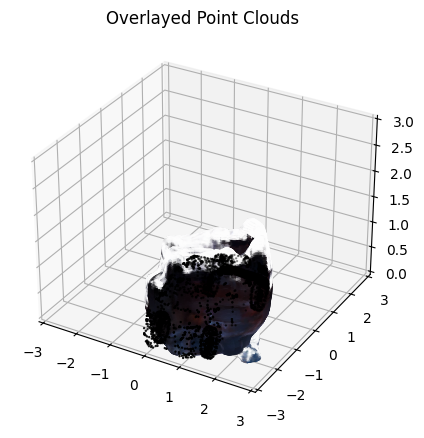

In [30]:
# Ensure synthetic_pc is a PyTorch tensor in homogeneous coordinates
synthetic_pc_homo = torch.cat((torch.tensor(synthetic_pc, dtype=torch.float32), torch.ones(synthetic_pc.shape[0], 1)), dim=1).to(device)

# Transform synthetic_pc using the trained model
transformed_synthetic_pc = transformer(synthetic_pc_homo)  # Assuming 'transformer' is your model instance

# Convert back to numpy for plotting, and drop the homogeneous coordinate
transformed_synthetic_pc_np = transformed_synthetic_pc.detach().cpu().numpy()[:, :3]

plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1, projection='3d')
ax.set_title('Overlayed Point Clouds')
ax.set_xlim([-3, 3])
ax.set_ylim([-3, 3])
ax.set_zlim([0, 3])

# Plot transformed synthetic point cloud
ax.scatter(transformed_synthetic_pc_np[:, 0], transformed_synthetic_pc_np[:, 2], -transformed_synthetic_pc_np[:, 1], c=colors/255.0, s=0.5)

# Plot twox_point_cloud
ax.scatter(twox_point_cloud[:, 0], twox_point_cloud[:, 2], -twox_point_cloud[:, 1], color='black', s=0.5)

plt.show()

(4646, 3) (35974, 3)
Iteration 1, Loss: 2.4809420108795166


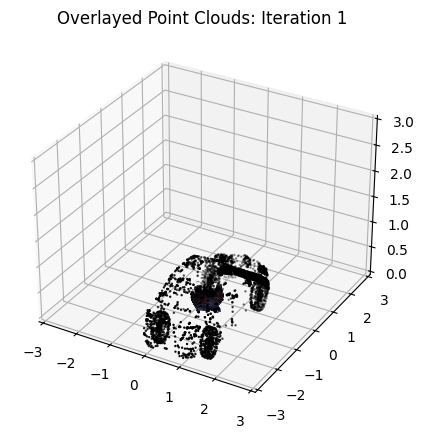

Iteration 2, Loss: 1.6866399049758911


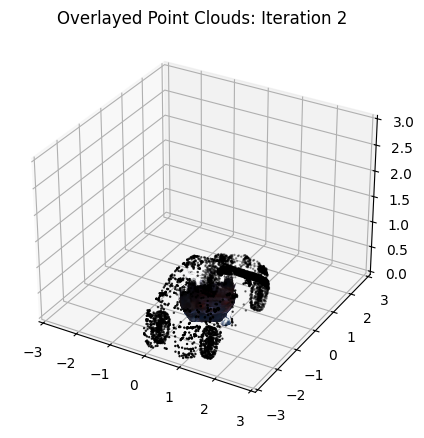

Iteration 3, Loss: 1.125382423400879


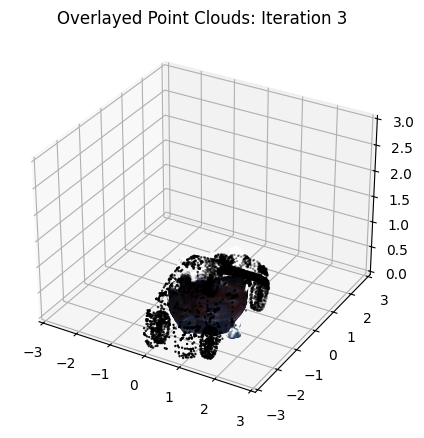

Iteration 4, Loss: 0.8004204034805298


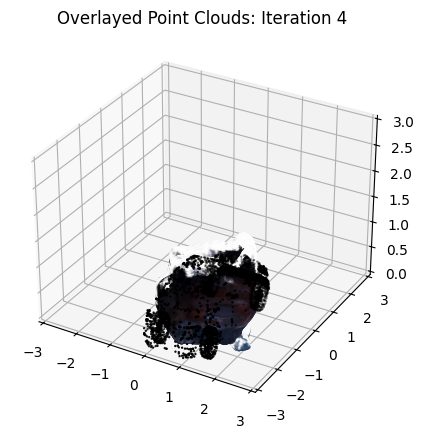

Iteration 5, Loss: 0.6750043630599976


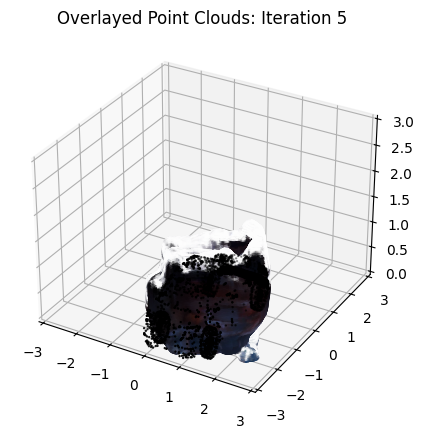

Iteration 6, Loss: 0.6907757520675659


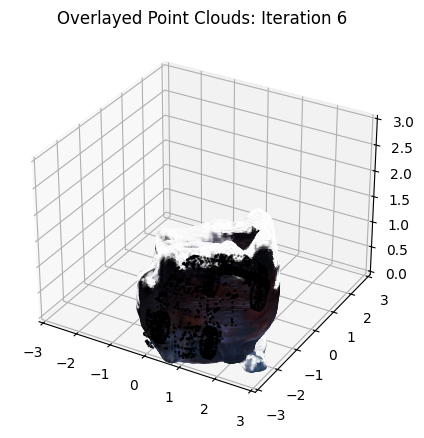

Iteration 7, Loss: 0.7833333611488342


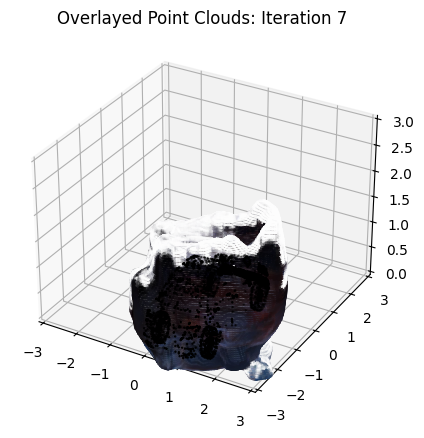

Iteration 8, Loss: 0.8924592733383179


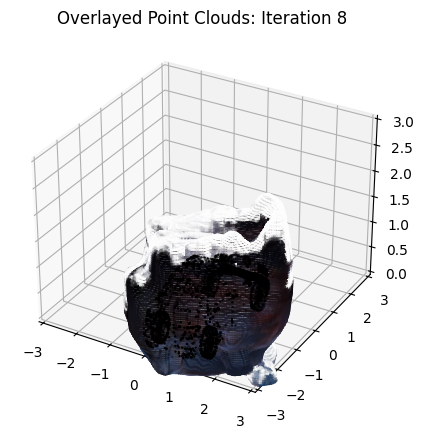

Iteration 9, Loss: 0.9769104719161987


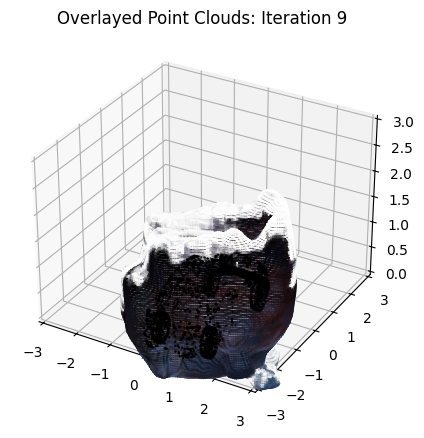

Iteration 10, Loss: 1.0156458616256714


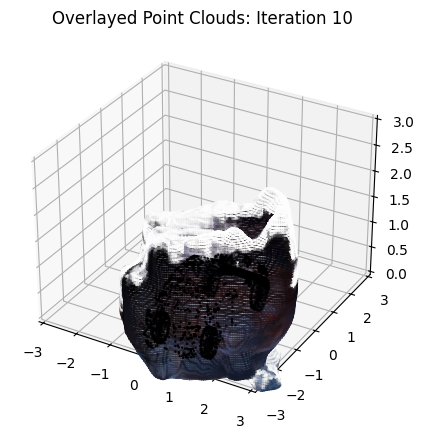

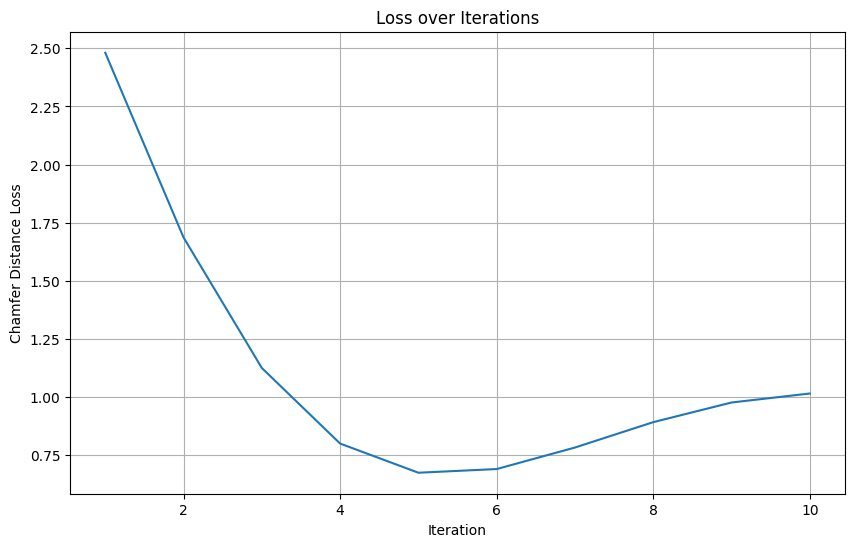

In [31]:
print(twox_point_cloud.shape, synthetic_pc.shape)
twax_pc_homo = torch.tensor(np.hstack((twox_point_cloud, np.ones((twox_point_cloud.shape[0], 1)))), dtype=torch.float32).to(device)
synthetic_pc_homo = torch.tensor(np.hstack((synthetic_pc, np.ones((synthetic_pc.shape[0], 1)))), dtype=torch.float32).to(device)
# Step 2: Set Up the Optimization Loop
# Initialize the transformer
transformer = PointCloudTransformer().to(device)

# Target point cloud (make sure to define this)
target_points = twax_pc_homo


# Initialize the optimizer
optimizer = optim.Adam(transformer.parameters(), lr=.8)

# Dummy source point cloud for demonstration
source_points = synthetic_pc_homo

num_iterations = 10
loss_record = []

# Move source and target points to device
source_points = source_points.to(device)  # Make sure source_points are in the correct format and on GPU
target_points = target_points.to(device)  # Make sure target_points are in the correct format and on GPU

for i in range(num_iterations):
    optimizer.zero_grad()
    
    # Apply transformation
    transformed_points = transformer(source_points)
    
    # Compute Chamfer Distance Loss
    loss = chamfer_distance(transformed_points, target_points)
    
    # Backpropagation
    loss.backward()
    optimizer.step()
    
    # Record loss for plotting
    loss_record.append(loss.item())
    
    print(f"Iteration {i+1}, Loss: {loss.item()}")

    # Plotting the transformation after each iteration
    transformed_points_np = transformed_points.detach().cpu().numpy()[:, :3]
    target_points_np = target_points.detach().cpu().numpy()[:, :3]  # Assuming target_points is also in homogeneous coordinates
    
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.clear()
    ax.set_title(f'Overlayed Point Clouds: Iteration {i+1}')
    ax.set_xlim([-3, 3])
    ax.set_ylim([-3, 3])
    ax.set_zlim([0, 3])
    
    # Adjusting the plotting as per the given format
    ax.scatter(transformed_points_np[:, 0], transformed_points_np[:, 2], -transformed_points_np[:, 1], c=colors/255.0, s=0.5)
    ax.scatter(target_points_np[:, 0], target_points_np[:, 2], -target_points_np[:, 1], color='black', s=0.5)
    
    plt.show()

# Graph the loss after all iterations
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_iterations + 1), loss_record)
plt.title('Loss over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Chamfer Distance Loss')
plt.grid(True)
plt.show()

Using device: cuda
Iteration 1, Loss: 2.19372296333313


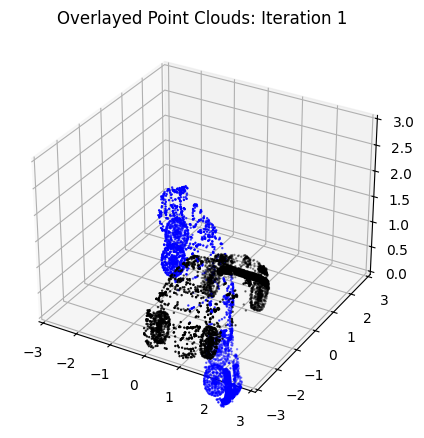

Iteration 2, Loss: 1.73270583152771


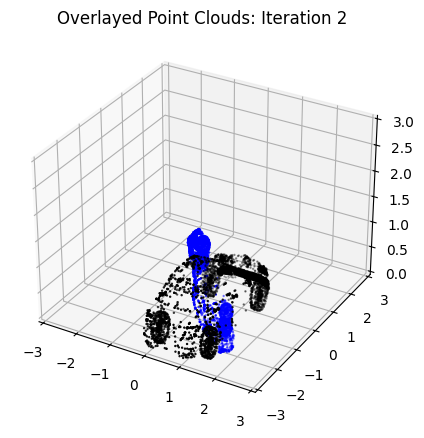

Iteration 3, Loss: 4.19771146774292


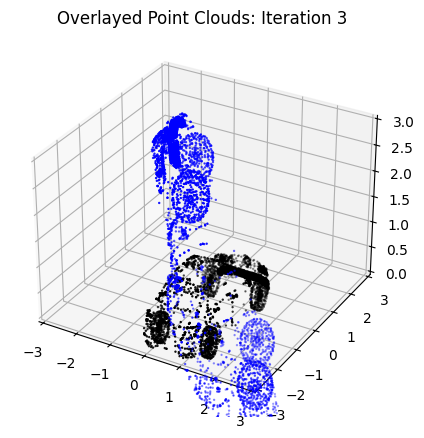

Iteration 4, Loss: 26.527179718017578


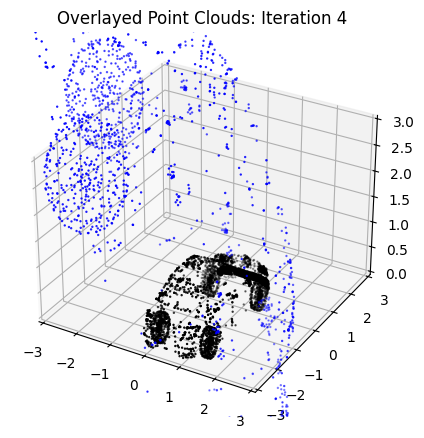

Iteration 5, Loss: 477.3727111816406


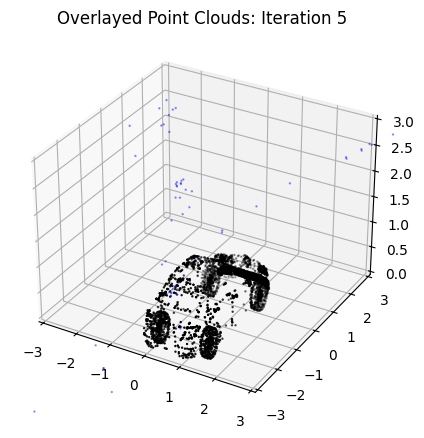

Iteration 6, Loss: 11191.474609375


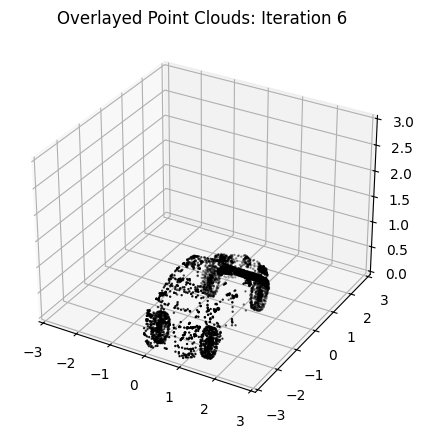

Iteration 7, Loss: 265715.5625


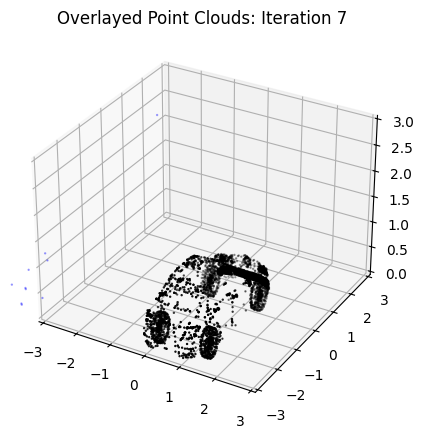

Iteration 8, Loss: 6352047.0


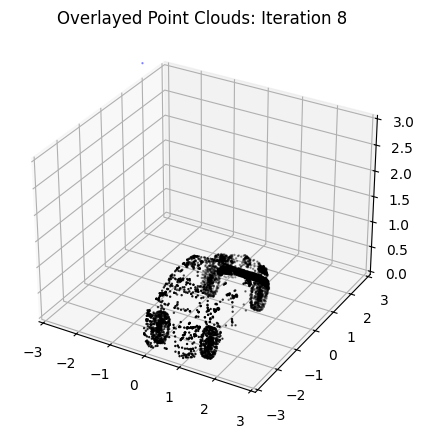

Iteration 9, Loss: 152051168.0


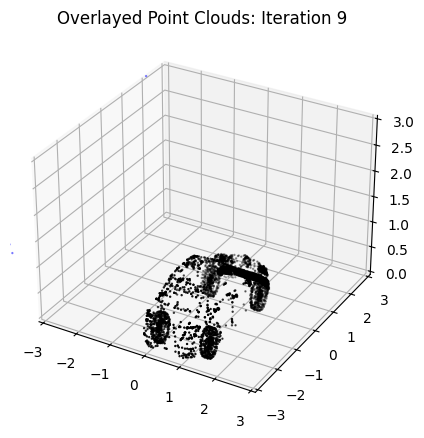

Iteration 10, Loss: 3640682752.0


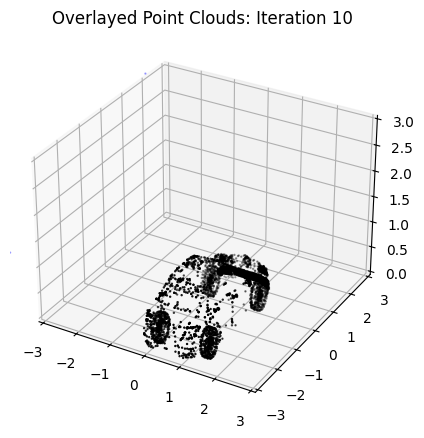

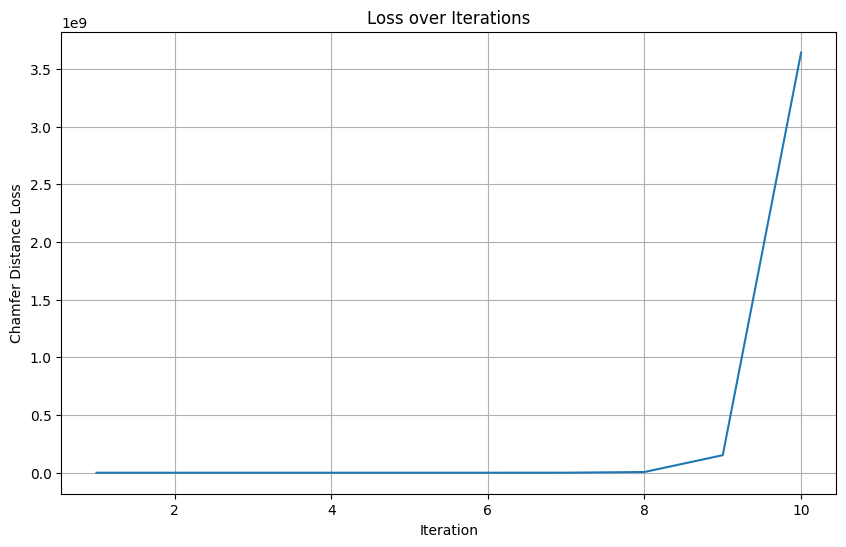

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Assuming twox_point_cloud and synthetic_pc are given numpy arrays
twax_pc_homo = torch.tensor(np.hstack((twox_point_cloud, np.ones((twox_point_cloud.shape[0], 1)))), dtype=torch.float32).to(device)
original_pc_homo = torch.tensor(np.hstack((twox_point_cloud, np.ones((twox_point_cloud.shape[0], 1)))), dtype=torch.float32).to(device)

# Random transformation parameters
random_tx = torch.tensor(0.0).to(device)
random_ty = torch.tensor(0.0).to(device)
random_tz = torch.tensor(0.0).to(device)
random_theta_x = torch.randn(1).to(device) * 1
random_theta_y = torch.randn(1).to(device) * 1
random_theta_z = torch.randn(1).to(device) * 1

#assign 1 to scale

random_s = torch.tensor(1.0).to(device)

# Apply random transformation to original point cloud
S_random = torch.diag(torch.stack([random_s.squeeze(), random_s.squeeze(), random_s.squeeze(), torch.tensor(1.0, device=device)])).to(device)
Rx_random = torch.tensor([[1, 0, 0, 0],
                          [0, torch.cos(random_theta_x), -torch.sin(random_theta_x), 0],
                          [0, torch.sin(random_theta_x), torch.cos(random_theta_x), 0],
                          [0, 0, 0, 1]], device=device)
Ry_random = torch.tensor([[torch.cos(random_theta_y), 0, torch.sin(random_theta_y), 0],
                          [0, 1, 0, 0],
                          [-torch.sin(random_theta_y), 0, torch.cos(random_theta_y), 0],
                          [0, 0, 0, 1]], device=device)
Rz_random = torch.tensor([[torch.cos(random_theta_z), -torch.sin(random_theta_z), 0, 0],
                          [torch.sin(random_theta_z), torch.cos(random_theta_z), 0, 0],
                          [0, 0, 1, 0],
                          [0, 0, 0, 1]], device=device)
T_random = torch.tensor([[1, 0, 0, random_tx],
                         [0, 1, 0, random_ty],
                         [0, 0, 1, random_tz],
                         [0, 0, 0, 1]], device=device)

M_random = T_random.mm(Rz_random).mm(Ry_random).mm(Rx_random).mm(S_random)
synthetic_pc_homo = original_pc_homo.mm(M_random.t())

# Step 2: Set Up the Optimization Loop
transformer = PointCloudTransformer().to(device)
optimizer = optim.SGD(transformer.parameters(), lr=0.8)

target_points = twax_pc_homo
source_points = synthetic_pc_homo

num_iterations = 10
loss_record = []

for i in range(num_iterations):
    optimizer.zero_grad()
    
    transformed_points = transformer(source_points)
    loss = chamfer_distance(transformed_points[:, :3], target_points[:, :3])
    
    loss.backward()
    optimizer.step()
    
    loss_record.append(loss.item())
    print(f"Iteration {i+1}, Loss: {loss.item()}")
    
    # Plotting the transformation
    transformed_points_np = transformed_points.detach().cpu().numpy()[:, :3]
    target_points_np = target_points.detach().cpu().numpy()[:, :3]
    
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.clear()
    ax.set_title(f'Overlayed Point Clouds: Iteration {i+1}')
    ax.set_xlim([-3, 3])
    ax.set_ylim([-3, 3])
    ax.set_zlim([0, 3])
    
    ax.scatter(transformed_points_np[:, 0], transformed_points_np[:, 2], -transformed_points_np[:, 1], c='blue', s=0.5)
    ax.scatter(target_points_np[:, 0], target_points_np[:, 2], -target_points_np[:, 1], color='black', s=0.5)
    
    plt.show()

# Graph the loss after all iterations
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_iterations + 1), loss_record)
plt.title('Loss over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Chamfer Distance Loss')
plt.grid(True)
plt.show()

: 